In [161]:
import seaborn as sns
sns.set_style("whitegrid")
from process_model import *
from fit_process import *

from scipy.stats import norm
from scipy.stats.mstats import mquantiles
    
#from chase.base import *
#from chase.utils import *
#from chase.fit import *

import pickle

PARS = {'theta': [0, 100, 3],
        'p_stay': [0, 1, .1],
        'p_fixed': [0, 1, .1],
        'p_stop_geom': [0, 1, .5],
        'tau': [.001, 50],
        'tau_unif': [0, 1],
        'prelec_gamma': [.01, 3],
        'prelec_elevation': [.01, 3],
        'prelec_gamma_loss': [.01, 3],
        'prelec_elevation_loss': [.01, 3],
        'pow_gain': [0., 5],
        'w_loss': [0., 10],
        'phi': [0, 100]}



def expected_value(options):
    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    return np.sum(v, 1)


def evar(options):

    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    # expected variance of each option
    evar = np.array([np.dot(weights[i], values[i] ** 2) - np.sum(v[i]) ** 2 for i in range(len(options))])

    return evar

def max_ev(options):
    ev = expected_value(options)
    if ev[0] > ev[1]:
        return [1, 0]
    else:
        return [0, 1]


def max_var(options):
    v = evar(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def cv(options):
    ev = expected_value(options)
    sd = np.sqrt(evar(options))    
    return sd / ev


def max_cv(options):
    v = cv(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def pfix(p):
    c = 1e-5
    return np.min([np.max([p, c]), 1 - c])


P_STOP_GEOM = {'HBWE': .053418,
               'HPKH1': 0.07666,
               'HPKH2': 0.02627}

P_SWITCH = {'HBWE': .25,
            'HPKH1': .185,
            'HPKH2': .11}

bf_par = {}

cp = {}
bf_cp = {}

quant = {}
bf_quant = {}

N_ITER = 1

In [162]:
FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/CHASE Paper/figures'

In [163]:
problems = {}
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
for i in range(len(arr)):
    problems[i] = arr[i].reshape((2,2,2))

# Predictions

In [77]:
pars = {'minsamplesize': 2,
        'N': 10000,
        'pref_units': 'sums',
        'p_stop_geom': .1}


m = CHASEProcessModel(problems=problems,
                      startdist='indifferent',
                      stoprule='fixedGeom')

results = {}
arr = []

#for t in [100, 300, 500, 1000, 5000]:
for t in [500]:
    pars['max_T'] = t
    
    for pid in problems:
        pars['probid'] = pid
        r = m(problems[pid], pars)
        results[(pid, t)] = r
        
        arr.append([pid, t, r['choice'].mean(), np.median(r['samplesize'])])
df = pd.DataFrame(arr, columns=['problem', 'T', 'p(H)', 'median_ss'])

In [78]:
results[(0,500)]['samplesize'].min()

2

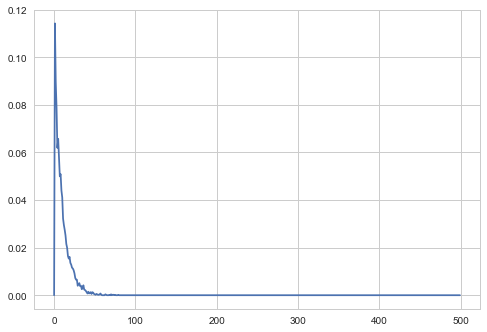

In [81]:
plt.plot(results[(0,500)]['p_stop_cond'][:,1])

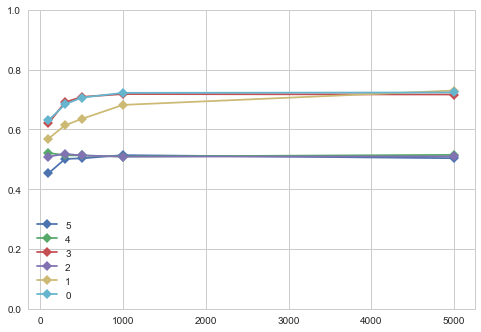

In [50]:
fig, ax = plt.subplots()
for pid in [5, 4, 3, 2, 1, 0]:
    ax.plot([100, 300, 500, 1000, 5000], df[df.problem==pid]['p(H)'], '-D', label=pid)
ax.legend()
ax.set_ylim(0, 1)
plt.show()

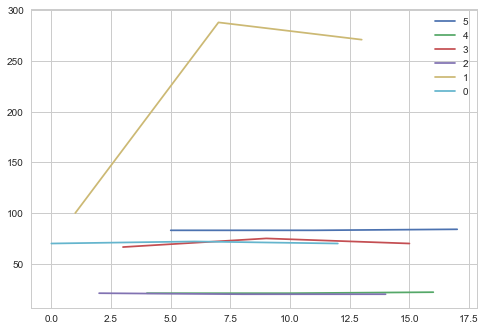

In [28]:
fig, ax = plt.subplots()
for pid in [5, 4, 3, 2, 1, 0]:
    ax.plot(df[df.problem==pid]['median_ss'], label=pid)
ax.legend()
plt.show()

In [275]:
pars = {'minsamplesize': 2,
        'theta': 30,
        'N': 1000,
        'pref_units': 'sums'}


m = CHASEProcessModel(problems=problems,
                      startdist='indifferent')

results = {}
arr = []

for theta in [5, 7, 10, 20]:
    pars['theta'] = theta
    
    for pid in problems:
        pars['probid'] = pid
        r = m(problems[pid], pars)
        results[(pid, theta)] = r
        
        arr.append([pid, theta, r['choice'].mean(), np.median(r['samplesize'])])

In [276]:
df = pd.DataFrame(arr, columns=['problem', 'theta', 'p(H)', 'median_ss'])

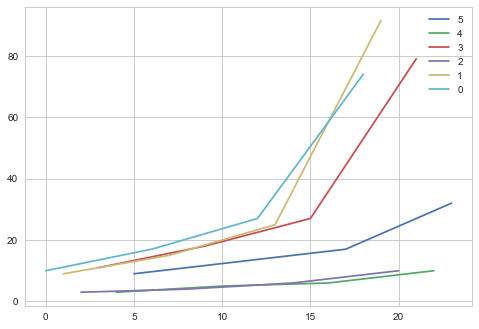

In [277]:
fig, ax = plt.subplots()
for pid in [5, 4, 3, 2, 1, 0]:
    ax.plot(df[df.problem==pid]['median_ss'], label=pid)
ax.legend()
plt.show()

In [278]:
np.median(results[(pid,7)]['samplesize'])

17.0

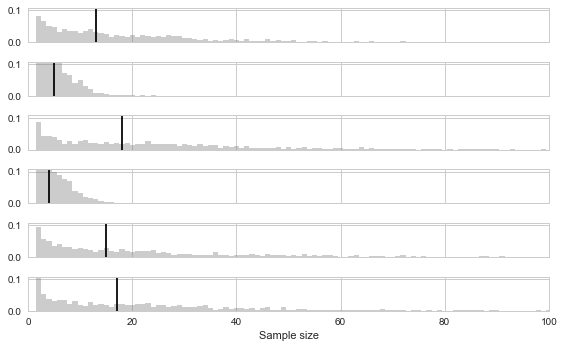

In [279]:
fig, ax = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(8,5))
for i, pid in enumerate([5,4,3,2,1,0]):
    med = np.median(results[(pid,7)]['samplesize'])
    bc = np.bincount(results[(pid,7)]['samplesize'])
    bc = bc/float(bc.sum())
    
    ax[i].bar(range(len(bc)), bc, width=1, color='gray', alpha=.4)
    ax[i].plot([med, med], [0,1], color='black')
    ax[i].set_xlim(0, 100)
    ax[i].set_ylim(0, bc.max())
    
ax[5].set_xlabel('Sample size')

plt.tight_layout()
plt.show()
#fig.savefig('sixproblems_prediction.png', bbox_inches='tight')

# Fit stopping distributions

In [165]:
from scipy.stats import geom
from scipy.optimize import minimize

def nloglik_geom(value, data, pars):
    print value
    if value < 0 or value > 1:
        return np.inf
    else:    
        minss = pars.get('minsamplesize', 2)
        ss = data.samplesize.values
        p = geom.pmf(ss, value, loc=(minss-1))
        return -np.sum(np.log(p))
    
def fit_geom(data, pars):
    f = minimize(nloglik_geom, np.random.random(), (data, pars), method='Nelder-Mead')
    return f

In [181]:
pars = {'minsamplesize': 2}
data = pd.read_csv('paper/data/hertwig2004/hertwig2004_data.csv', index_col=0).reset_index()

f = fit_geom(data, pars)
P_STOP_GEOM['hertwig2004'] = np.round(f['x'][0], 3)

data = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==1]
f = fit_geom(data, pars)
P_STOP_GEOM['hau2008_exp1'] = np.round(f['x'][0], 3)

data = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==2]
f = fit_geom(data, pars)
P_STOP_GEOM['hau2008_exp2'] = np.round(f['x'][0], 3)

[ 0.0330944]
[ 0.03474912]
[ 0.03640384]
[ 0.03805856]
[ 0.041368]
[ 0.04467744]
[ 0.05129631]
[ 0.05791519]
[ 0.05791519]
[ 0.04798687]
[ 0.05460575]
[ 0.04964159]
[ 0.04798687]
[ 0.05046895]
[ 0.05129631]
[ 0.05005527]
[ 0.04964159]
[ 0.05026211]
[ 0.05046895]
[ 0.05015869]
[ 0.05036553]
[ 0.0502104]
[ 0.07186205]
[ 0.07545515]
[ 0.07904825]
[ 0.0772517]
[ 0.07904825]
[ 0.07635343]
[ 0.07545515]
[ 0.07680257]
[ 0.0772517]
[ 0.076578]
[ 0.07635343]
[ 0.07669028]
[ 0.07680257]
[ 0.07663414]
[ 0.8755476]
[ 0.91932498]
[ 0.83177022]
[ 0.78799284]
[ 0.70043808]
[ 0.61288332]
[ 0.4377738]
[ 0.26266428]
[-0.08755476]
[ 0.4377738]
[ 0.08755476]
[-0.08755476]
[-0.08755476]
[ 0.17510952]
[  2.22044605e-15]
[ 0.13133214]
[ 0.04377738]
[  2.22044605e-15]
[  2.22044605e-15]
[ 0.06566607]
[ 0.02188869]
[  2.22044605e-15]
[  2.22044605e-15]
[ 0.03283303]
[ 0.01094434]
[ 0.02736086]
[ 0.03283303]
[ 0.02462478]
[ 0.03009695]
[ 0.02599282]
[ 0.02462478]
[ 0.02667684]
[ 0.0253088]
[ 0.02633483]
[ 0.026

In [182]:
P_STOP_GEOM

{'HBWE': 0.053418,
 'HPKH1': 0.07666,
 'HPKH2': 0.02627,
 'hau2008_exp1': 0.076999999999999999,
 'hau2008_exp2': 0.025999999999999999,
 'hertwig2004': 0.050000000000000003}

In [190]:
P_STOP_GEOM = {'hertwig2004': 0.05,
               'hau2008_exp1': 0.077,
               'hau2008_exp2': 0.026}

# Fit HBWE04

In [225]:
data = pd.read_csv('paper/data/hertwig2004/hertwig2004_data.csv', index_col=0).reset_index()
SIM_ID = 'process_planned_hertwig2004'
OUTDIR = 'process_planned_fitresults_hertwig2004'

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000,
         'p_stop_geom': P_STOP_GEOM['hertwig2004']}

PARSETS = [#['tau'],
           #['tau', 'pow_gain'],
           #['tau', 'prelec_gamma', 'prelec_elevation'],
           ['tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           #['tau', 'p_stay', 'prelec_gamma', 'prelec_elevation'],
           ]
m = CHASEProcessModel(problems=problems,
                      startdist='laplace',
                      stoprule='fixedGeom')

In [226]:
#for pu in ['sums', 'diffs']:
for pu in ['diffs']:

    FIXED['pref_units'] = pu
    
    for parset in PARSETS:

        fitting = {p: PARS[p] for p in parset}
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

pow_gain	prelec_elevation	prelec_gamma	tau


process_model.py:81: RuntimeWarning: invalid value encountered in divide
  # sequential weights


[  0.612   2.273   1.489  26.875] 744.84003312


process_model.py:366: RuntimeWarning: invalid value encountered in divide
  p_stop_A[stop_T-1] = 1


[  1.373   2.847   1.667  29.815] 754.474829287
[  0.328   0.865   1.807  16.324] 735.688733786
[  0.523   2.901   0.637  15.186] 923.219973005
[ 0.136  2.317  2.344  8.295] 745.49569415
[  2.70000000e-02   1.16100000e+00   1.76900000e+00   3.54810000e+01] 744.003923499
[  0.85    2.652   0.724  10.356] 919.857252428
[ 0.117  2.171  0.606  0.062] 955.782246643
[  0.266   0.551   1.454  32.595] 700.25796309
[ 1.261  0.433  1.605  3.879] 723.652669191
[  1.402   0.221   1.349  40.692] 742.715625724
[  0.533   2.149   1.172  12.534] 780.383469876
[  1.382   1.605   1.387  13.961] 735.862145819
[  0.778   2.756   1.24   36.991] 780.474029491
[  0.564   2.748   1.936  31.989] 741.233645791
[  0.297   0.666   0.85   43.354] 695.541198066
[  1.12    1.232   0.081  19.566] 905.795536417
[  0.86    0.48    2.066  11.85 ] 696.876716493
[  1.487   0.205   2.833  18.205] 727.221550909
[  1.103   2.232   1.521  36.459] 751.228649544
[  0.358   2.986   0.669  17.273] 918.097199543
[  1.056   2.092  

In [189]:
FIXED

{'N': 20000,
 'max_T': 1000,
 'minsamplesize': 2,
 'p_stop_geom': 0.05,
 'pref_units': 'sums'}

In [224]:
for fitting in PARSETS:
    print best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          678.578
k                                                                   4
N                                                                 150
bic                                                            1377.2
pow_gain                                                     0.712789
prelec_elevation                                             0.674158
prelec_gamma                                                  1.43785
tau                                                           2.96099
sim_id              process_planned_hertwig2004(pow_gain,prelec_el...
Name: 0, dtype: object


In [205]:
fitting = PARSETS[0]
best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)
print best

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          679.311
k                                                                   4
N                                                                 150
bic                                                           1378.66
p_stay                                                       0.290053
prelec_elevation                                             0.263991
prelec_gamma                                                  2.80678
tau                                                           5.95851
sim_id              process_planned_hertwig2004(p_stay,prelec_elev...
Name: 0, dtype: object


In [206]:
bf_par[SIM_ID] = best

cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean().values

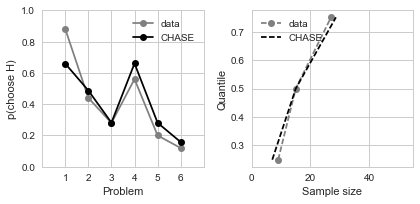

In [207]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

# Hau et al 2008

In [236]:
SIM_ID = 'process_hau_exp1'
OUTDIR = 'process_fitresults_hau_exp1'
data = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==1]

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000,
         'p_stop_geom': P_STOP_GEOM['hau2008_exp1']}

PARSETS = [#['tau'],
           #['tau', 'pow_gain'],
           #['tau', 'prelec_gamma', 'prelec_elevation'],
           ['tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           #['tau', 'p_stay', 'prelec_gamma', 'prelec_elevation'],
           ]
m = CHASEProcessModel(problems=problems,
                      startdist='laplace',
                      stoprule='fixedGeom')

In [237]:
for pu in ['sums', 'diffs']:
#for pu in ['sums']:

    FIXED['pref_units'] = pu
    
    for fitting in PARSETS:
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

pow_gain	prelec_elevation	prelec_gamma	tau
[ 0.379  1.855  1.914  2.751] 979.153928516
[  0.887   1.636   0.274  24.145] 977.192436163
[  0.255   2.131   1.4    47.696] 977.646823407
[  0.165   0.666   1.005  40.591] 947.718916441
[  0.453   0.867   0.846  47.492] 945.503785037
[  0.324   1.091   1.316  28.235] 968.228046814
[ 0.951  1.264  1.061  5.584] 944.187063343
[  1.302   0.441   0.935  24.716] 978.585024665
[  1.347   0.333   1.807  32.656] 981.337357786
[ 1.411  2.727  1.408  4.293] 979.644519128
[  1.499   1.548   0.315  30.034] 981.217448213
[  0.291   0.058   0.88   26.903] 971.061394751
[  0.815   1.751   0.696  37.979] 950.656700623
[ 0.549  0.802  0.381  0.406] 961.086871407
[  0.834   2.964   0.108  43.549] 1044.19176297
[ 1.284  2.324  2.105  1.75 ] 992.441336608
[  0.346   1.925   1.97   42.418] 974.806121851
[  1.009   0.14    1.19   21.168] 980.794000952
[  0.999   0.459   0.791  33.878] 971.721155589
[  0.488   0.97    2.534  34.579] 981.233187441
[  0.762   2.388 

In [238]:
FIXED['pref_units'] = 'sums'
for fitting in PARSETS:
    print best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          940.276
k                                                                   4
N                                                                 230
bic                                                            1902.3
pow_gain                                                     0.521222
prelec_elevation                                             0.991293
prelec_gamma                                                  1.02107
tau                                                           7.94987
sim_id              process_hau_exp1(pow_gain,prelec_elevation,pre...
Name: 0, dtype: object


In [210]:
fitting = PARSETS[0]
best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)
print best

bf_par[SIM_ID] = best

cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean().values

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          941.743
k                                                                   4
N                                                                 230
bic                                                           1905.24
p_stay                                                       0.338247
prelec_elevation                                               1.3039
prelec_gamma                                                  1.11828
tau                                                           72.9793
sim_id              process_hau_exp1(p_stay,prelec_elevation,prele...
Name: 0, dtype: object


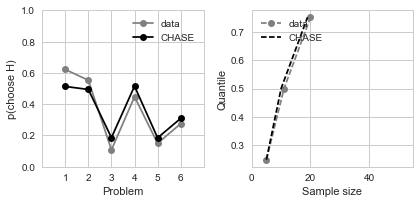

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

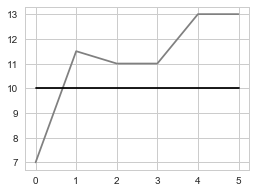

In [212]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(data.groupby('problem').apply(lambda d: np.median(d.samplesize)), color='gray')
ax.plot(pred.groupby('problem').apply(lambda d: np.mean(d['ss(.5)'])), color='black')
plt.show()

In [239]:
SIM_ID = 'process_planned_hau_exp2'
OUTDIR = 'process_planned_fitresults_hau_exp2'
data = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==2]

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000,
         'p_stop_geom': P_STOP_GEOM['hau2008_exp2']}

PARSETS = [#['tau'],
           #['tau', 'pow_gain'],
           #['tau', 'prelec_gamma', 'prelec_elevation'],
           ['tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           #['tau', 'p_stay', 'prelec_gamma', 'prelec_elevation'],
           ]
m = CHASEProcessModel(problems=problems,
                      startdist='laplace',
                      stoprule='fixedGeom')

In [240]:
for pu in ['sums', 'diffs']:
#for pu in ['sums']:

    FIXED['pref_units'] = pu
    
    for fitting in PARSETS:
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

pow_gain	prelec_elevation	prelec_gamma	tau
[  1.317   2.152   1.179  45.968] 1390.0889791
[  0.598   1.57    2.888  16.843] 1382.37303842
[ 0.691  1.047  1.616  2.253] 1409.31093461
[  1.359   0.658   2.691  42.683] 1455.18720233
[  0.744   0.133   2.724  10.616] 1313.39111616
[ 0.27   2.43   2.348  5.762] 1370.64277937
[  1.278   0.857   0.835  37.05 ] 1307.42341395
[ 1.111  0.372  1.785  3.336] 1316.64115886
[  0.96    1.853   1.051  13.084] 1384.73177698
[ 1.097  0.193  0.52   7.072] 1326.13571509
[ 0.524  0.771  2.428  0.786] 1423.66258365
[  0.148   1.248   1.968  44.439] 1385.05860783
[  0.39    2.549   1.304  31.597] 1378.20730989
[  0.031   0.518   1.373  20.951] 1356.64553769
[  0.995   2.996   0.963  27.83 ] 1398.38091123
[ 0.16   0.284  0.289  4.567] 1244.65252824
[ 0.554  0.343  2.978  5.899] 1424.92920424
[  1.202   1.429   0.386  27.338] 1309.37602905
[  0.839   1.127   0.58   23.192] 1260.71332599
[  1.057   0.671   2.757  40.247] 1451.62951085
[ 0.646  2.771  1.465  7.9

In [241]:
for fitting in PARSETS:
    b = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    print b['sim_id']
    print b

process_planned_hau_exp2(pow_gain,prelec_elevation,prelec_gamma,tau|N=20000,max_T=1000,minsamplesize=2,p_stop_geom=0.026,pref_units=diffs)
index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1241.45
k                                                                   4
N                                                                 234
bic                                                           2504.72
pow_gain                                                     0.322372
prelec_elevation                                             0.477319
prelec_gamma                                                 0.928543
tau                                                           41.3904
sim_id              p

In [242]:
fitting = PARSETS[0]
best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, fitting=fitting, outdir=OUTDIR)
print best

bf_par[SIM_ID] = best
cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean().values

/Users/markant/code/chase/chase/cpt.py:40: RuntimeWarning: divide by zero encountered in log
  f = np.exp(-delta * ((-np.log(p)) ** gamma))


index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1241.45
k                                                                   4
N                                                                 234
bic                                                           2504.72
pow_gain                                                     0.322372
prelec_elevation                                             0.477319
prelec_gamma                                                 0.928543
tau                                                           41.3904
sim_id              process_planned_hau_exp2(pow_gain,prelec_eleva...
Name: 0, dtype: object


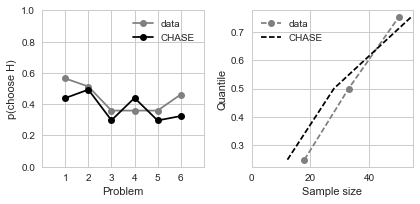

In [243]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

In [217]:
pred

,problem,cp,ss(.25),ss(.5),ss(.75)
0,0,0.414,12.0,28.0,54.0
1,1,0.497,12.0,28.0,54.0
2,2,0.347,13.0,28.0,54.0
3,3,0.416,12.0,28.0,54.0
4,4,0.347,12.0,28.0,54.0
5,5,0.436,13.0,28.0,54.0


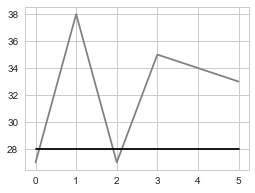

In [218]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(data.groupby('problem').apply(lambda d: np.median(d.samplesize)), color='gray')
ax.plot(pred.groupby('problem').apply(lambda d: np.mean(d['ss(.5)'])), color='black')
plt.show()

# Combine results

In [208]:
from mypy.viz import tableau20
labels = ['HBWE04', 'HPKH08, Exp 1', 'HPKH08, Exp 2']
studies = ['process_hertwig2004', 'process_hau_exp1', 'process_hau_exp2']

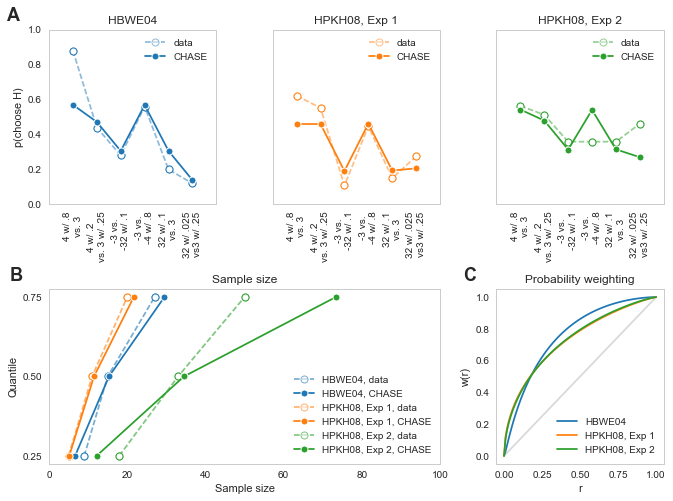

In [237]:
col = [tableau20[0], tableau20[2], tableau20[4]]

fig, ax = plt.subplots(2, 3, figsize=(9.5, 7), sharey=True)

ax[0][0].text(-.25, 1.05, 'A', fontsize=18, fontweight='semibold', transform=ax[0][0].transAxes)


for i, study in enumerate(studies):
    axi = ax[0][i]
    axi.plot(range(1, 7), cp[study], '--o', markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, color=col[i], alpha=.5,
             label='data')

    # hacky
    axi.plot(range(1, 7), cp[study], 'o', markerfacecolor='white', markeredgecolor=col[i],
             markeredgewidth=1)


    axi.plot(range(1, 7), bf_cp[study], '-o', markerfacecolor=col[i], markeredgecolor='white', 
             markeredgewidth=1, color=col[i], label='CHASE')
    axi.set_ylim(0, 1)
    axi.set_xlim(0, 7)
    axi.set_xticks(range(1,7))
    axi.set_xticklabels([problems_str[j] for j in range(6)], rotation=90)

    #axi.set_xlabel('Problem')
    
    axi.set_title(labels[i])
    axi.legend()
    axi.grid(None)

ax[0][0].set_ylabel('p(choose H)')

# sample size



axi = plt.subplot2grid((2,3), (1,0), colspan=2)
axi.text(-.1, 1.05, 'B', fontsize=18, fontweight='semibold', transform=axi.transAxes)

for i, study in enumerate(studies):

    axi.plot(quant[study], [.25, .5, .75], '--o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, label='%s, data' % labels[i], alpha=.6)
    
    # hacky
    axi.plot(quant[study], [.25, .5, .75], 'o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], markeredgewidth=1)

    axi.plot(bf_quant[study], [.25, .5, .75], '-o', color=col[i], 
             markerfacecolor=col[i], markeredgecolor='white',
             markeredgewidth=1, label='%s, CHASE' % labels[i])

axi.set_xlim(0, 100)
axi.legend(loc='lower right')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')
axi.set_yticks([.25, .5, .75])
axi.grid(None)
axi.set_title('Sample size')

# probability weighting

p = np.arange(0, 1.01, .01)
axi = plt.subplot2grid((2,3), (1,2))
axi.text(-.2, 1.05, 'C', fontsize=18, fontweight='semibold', transform=axi.transAxes)


axi.plot([0, 1], [0, 1], color='gray', alpha=.3)

for i, study in enumerate(studies):
    axi.plot(p, w_prelec(p, bf_par[study]['prelec_elevation'], bf_par[study]['prelec_gamma']), '-', 
             color=col[i], label=labels[i])

axi.set_title('Probability weighting')
axi.set_xlabel('r')
axi.set_ylabel('w(r)')
axi.legend(loc='lower right')
axi.grid(None)



plt.tight_layout()
plt.show()
fig.savefig('%s/fitresults_6problems.pdf' % FIGDEST, bbox_inches='tight')

In [204]:
problems_str = {0: '4 w/ .8\nvs. 3',
                1: '4 w/ .2\nvs. 3 w/ .25',
                2: '-3 vs.\n-32 w/ .1',
                3: '-3 vs.\n-4 w/ .8',
                4: '32 w/ .1\nvs. 3',
                5: '32 w/ .025\nvs3 w/ .25'}

# Fitting combined data

In [76]:
data1 = pd.read_csv('paper/data/hertwig2004/hertwig2004_data.csv', index_col=0)
data2 = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)

In [79]:
data = pd.concat((data1, data2))

In [101]:
SIM_ID = 'process_hertwig2004+hau2008'
OUTDIR = 'process_fitresults_hertwig2004+hau2008'

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000}

PARSETS = [#['theta', 'tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ['theta(group=HBWE04)', 'theta(group=HPKH08-1)', 'theta(group=HPKH08-2)', 
            'tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 
            'tau(group=HBWE04)', 'tau(group=HPKH08-1)', 'tau(group=HPKH08-2)',  
            'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 'tau', 
            'pow_gain(group=HBWE04)', 'pow_gain(group=HPKH08-1)', 'pow_gain(group=HPKH08-2)', 
            'prelec_gamma', 'prelec_elevation'],
           ['theta', 'tau', 'pow_gain', 
            'prelec_gamma(group=HBWE04)', 'prelec_gamma(group=HPKH08-1)', 'prelec_gamma(group=HPKH08-2)', 
            'prelec_elevation'],
           ['theta', 'tau', 'pow_gain', 'prelec_gamma', 
            'prelec_elevation(group=HBWE04)', 'prelec_elevation(group=HPKH08-1)', 'prelec_elevation(group=HPKH08-2)'],
           ]

m = CHASEProcessModel(problems=problems,
                      startdist='laplace')

In [97]:
#data.loc[data.group==0,'group'] = 'HBWE04'
#data.loc[data.group==1,'group'] = 'HPKH08-1'
#data.loc[data.group==2,'group'] = 'HPKH08-2'

In [102]:
for pu in ['sums']:

    FIXED['pref_units'] = pu
    
    for fitting in PARSETS:

        #fitting = {p: PARS[p] for p in parset}
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

pow_gain	prelec_elevation	prelec_gamma	tau	theta(group=HBWE04)	theta(group=HPKH08-1)	theta(group=HPKH08-2)
[  1.967   0.57    2.139  29.183  35.782   2.338  31.119] 4297.13235112
[  1.961   0.766   0.138  25.377  29.039  45.179  16.427] 3819.70130485
[  1.346   1.98    2.695  58.539  26.173  47.901  41.596] 4310.29050809
[  1.123   0.387   1.45   75.275   8.371  37.696  43.937] 3371.31893111
[  0.509   2.144   2.384  92.013   6.697   8.347  40.206] 4244.64083509
[  0.086   2.455   2.032  34.836  47.266   0.353   9.504] 4795.41688818
[  0.203   0.906   0.369  49.879  26.847  19.557   1.233] 4315.14197288
[  1.381   2.011   1.688  42.385  14.324   0.925  43.465] 4378.10847879
[  1.187   1.728   2.846  65.877  14.666   9.633  25.604] 4228.10555245
[  0.622   1.81    2.062   0.055  48.413   3.391   3.187] 5821.25017784
[  0.072   0.803   1.696  57.026  42.332  40.171  32.522] 4235.41112081
[  1.583   0.419   0.157  44.682  15.376  34.4    44.311] 3314.9365636
[  1.011   1.56    2.943  13.1

# Old

In [ ]:
HBWE_data = []

for i, grp in data.groupby(['subject', 'problem']):
    pid = grp.problem.values[0]
    
    ss = grp.shape[0]

    sampled_option = grp.option.values
    choice = grp.choice.values[-1]
    
    #coding = max_var(problems[pid])
    #sampled_option = np.array([coding[i] for i in grp.option.values])
    #choice = coding[grp.choice.values[-1]]
    
    if ss < cutoff:
        HBWE_data.append({'group': 0, 
                         'probid': pid,
                         'sampled_option': sampled_option,
                         'outcomes': grp.outcome.values,
                         'choice': choice,
                         'samplesize': ss})

### Baseline model

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel

N_ITER = 1
SIM_ID = 'process_baseline_HBWE04'
OUTDIR = 'process_baseline_fitresults_HBWE04'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [448]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,696.178344,1,150,1397.367324,0.053418


### Geom + two-stage

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel

N_ITER = 1
SIM_ID = 'process_2stage_HBWE04'
OUTDIR = 'process_2stage_fitresults_HBWE04'

FIXED = {'minsamplesize': 2,
         'p_stop_geom': .053418}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [451]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,664.271416,4,150,1348.585372,0.363671,0.31345,1.542747,2.729099


In [452]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_switch': .25,
            'p_stop_geom': .053418,
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

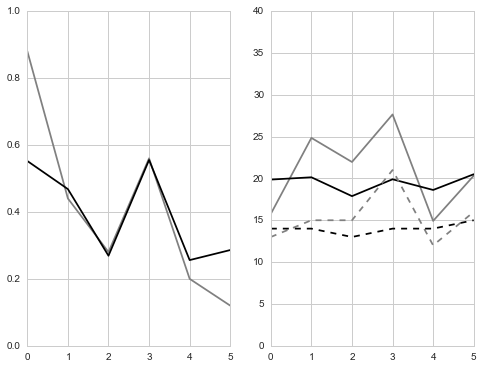

In [453]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE + geom

In [ ]:
SIM_ID = 'process_HBWE04'
OUTDIR = 'process_fitresults_HBWE04'
FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_stop_geom': .053418}
PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [455]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,716.13854,5,150,1457.330257,-0.000852,0.808129,0.995768,1.261691,0.643931


In [456]:
pred = {}
arr = []
for d in HBWE_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .053418,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

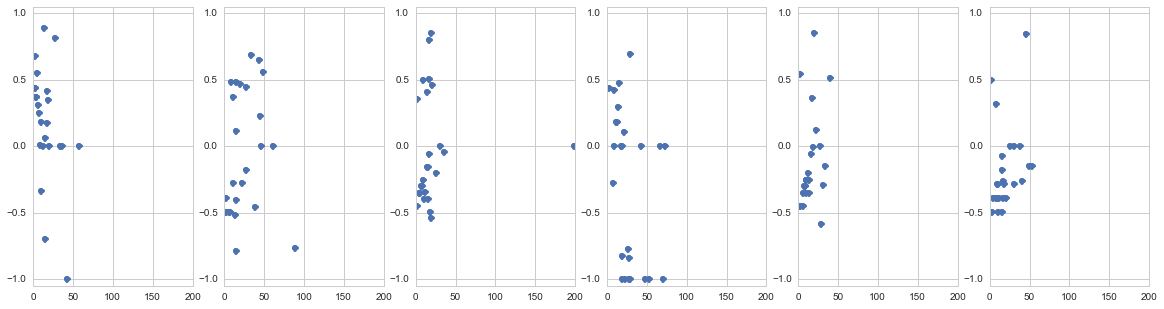

In [457]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,200)
plt.show()

In [461]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .053418,
            'p_switch': .25,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

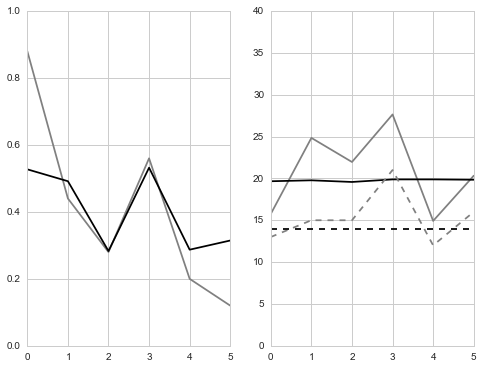

In [462]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE (optional stopping)

In [ ]:
N_ITER = 1
SIM_ID = 'process_hertwig2004'
OUTDIR = 'process_fitresults_hertwig2004'

FIXED = {'minsamplesize': 2,
         'p_switch': .25}
PARSETS = [['theta', 'tau', 'p_stay', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

In [428]:
results

,iteration,success,nllh,k,N,bic,p_stay,pow_gain,prelec_elevation,prelec_gamma,tau,theta
0,0,False,1305.835059,6,150,2641.73393,0.100995,0.561866,1.208618,1.073574,0.601972,2.784131


In [429]:
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
pred = {}
arr = []
for d in HBWE_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 0,
            'tau': results.loc[0]['tau'],
            'theta': results.loc[0]['theta'],
            'p_stay': results.loc[0]['p_stay'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

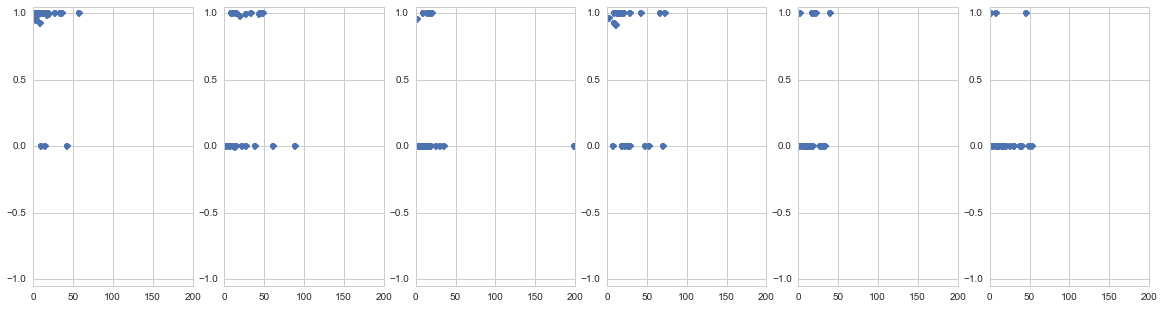

In [430]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,200)
plt.show()

In [432]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_switch': .25,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_stay': results.loc[0]['p_stay'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

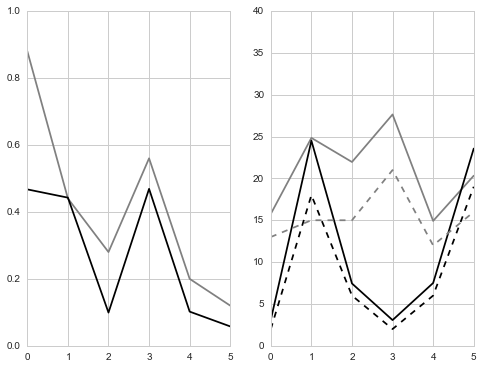

In [433]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

# Hau et al. (2008) - Experiment 1

In [ ]:
from mypy.explib.hau2008 import hau2008
HPKH1_data = hau2008.trial_data(study=1)

### Baseline

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel

N_ITER = 1
SIM_ID = 'process_baseline_HPKH1'
OUTDIR = 'process_baseline_fitresults_HPKH1'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [435]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,971.079115,1,230,1947.596308,0.07666


### Two-stage + geom

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel
N_ITER = 1
SIM_ID = 'process_2stage_HPKH1'
OUTDIR = 'process_2stage_fitresults_HPKH1'
FIXED = {'minsamplesize': 2,
         'p_stop_geom': .07666}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [437]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,902.001973,4,230,1825.756263,0.318952,0.60701,0.65675,4.775384


In [438]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

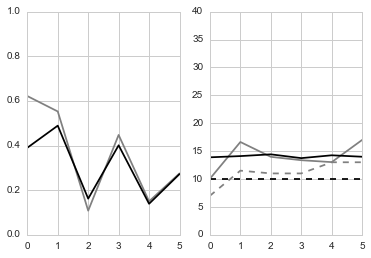

In [440]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE + geom

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH1'
OUTDIR = 'process_fitresults_HPKH1'

FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_switch': .185,
         'p_stop_geom': .07666}

PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [464]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,978.880092,5,230,1984.95058,0.000303,0.615612,1.175495,1.13464,0.540726


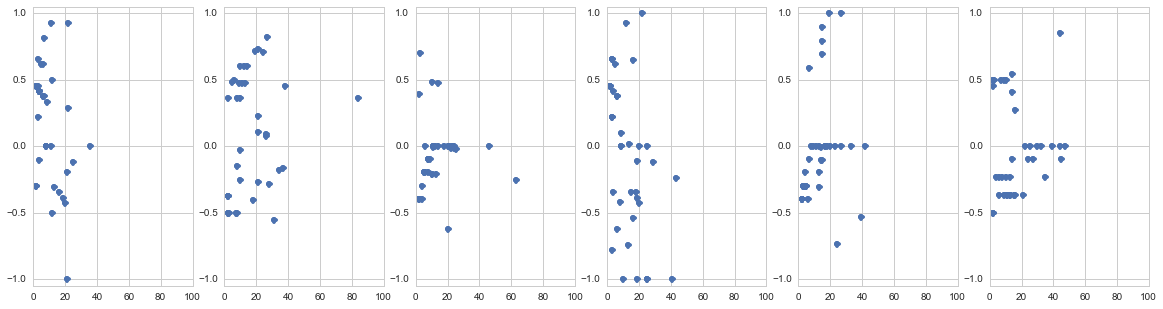

In [469]:
pred = {}
arr = []
for d in HPKH1_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,100)
plt.show()

In [470]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'p_switch': .185,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

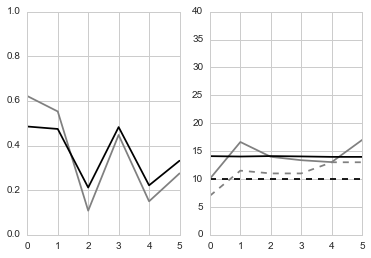

In [471]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE (optional)

In [446]:
N_ITER = 1
SIM_ID = 'process_HPKH1'
OUTDIR = 'process_fitresults_HPKH1'

FIXED = {'minsamplesize': 2,
         'p_switch': .185}
PARSETS = [['theta', 'tau', 'p_stay', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

p_stay	pow_gain	prelec_elevation	prelec_gamma	tau	theta
[ 0.1  1.   1.   1.   0.5  3. ] 2218.26060337 29.2593390942
[ 0.105  1.     1.     1.     0.5    3.   ] 2214.81868901 30.4063830376
[ 0.1   1.05  1.    1.    0.5   3.  ] 2225.2878659 31.8709230423
[ 0.1   1.    1.05  1.    0.5   3.  ] 2213.92925523 33.0243399143
[ 0.1   1.    1.    1.05  0.5   3.  ] 2212.7794734 32.9617190361
[ 0.1    1.     1.     1.     0.525  3.   ] 2196.50652517 31.0505108833
[ 0.1   1.    1.    1.    0.5   3.15] 2224.99277198 30.456193924
[ 0.102  0.95   1.017  1.017  0.508  3.05 ] 2207.18330184 30.4067790508
[ 0.102  0.983  1.022  1.022  0.511  2.867] 2191.41094463 30.4521679878
[ 0.103  0.975  1.033  1.033  0.517  2.725] 2149.34119405 27.1496319771
[ 0.103  0.975  1.033  1.033  0.517  2.925] 2205.91976808 26.9705290794
[ 0.098  0.967  1.044  1.044  0.522  2.9  ] 2174.99396264 28.9825470448
[ 0.102  0.956  0.993  1.059  0.53   2.867] 2149.09493142 28.6417989731
[ 0.103  0.933  0.964  1.089  0.544  2.8  ] 214

KeyboardInterrupt: 

In [ ]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_switch': .25,
            #'phi': results.loc[0]['phi'],
            'p_fixed': results.loc[0]['p_fixed'],
            'p_stop_geom': results.loc[0]['p_stop_geom'],
            #'prelec_gamma': results.loc[0]['prelec_gamma'],
            #'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

In [ ]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot([pred[pid]['p_resp'][1] for pid in problems])
ax.set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems])
ax.plot([pred[pid]['samplesize'].mean() for pid in problems])
ax.set_ylim(0,40)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems])
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems])
ax.set_ylim(0,40)
plt.show()

# Hau et al (2008) - Experiment 2

In [ ]:
HPKH2_data = hau2008.trial_data(study=2)

In [472]:
# confirm the right choice proportions and sample sizes
for pid in range(6):
    data = filter(lambda d: d['probid']==pid, HPKH2_data)
    print pid, np.round(np.mean([d['choice'] for d in data]), 2), np.median([d['samplesize'] for d in data])

0 0.56 27.0
1 0.51 38.0
2 0.36 27.0
3 0.36 35.0
4 0.36 34.0
5 0.46 33.0


In [ ]:
arr = []
for d in HPKH2_data:
    sampled_option = d['sampled_option']
    outcomes = d['outcomes']
    sum_L = np.sum(outcomes[sampled_option==0])
    sum_H = np.sum(outcomes[sampled_option==1])
    arr.append([d['probid'], sum_H - sum_L, d['choice']])
df = pd.DataFrame(arr, columns=['problem', 'diff', 'choice'])

sns.lmplot(x="diff", y="choice", data=df,
           logistic=True, y_jitter=.03)

sns.lmplot(x="diff", y="choice", data=df[(df['diff'] < 100) & (df['diff'] > -100)],
           logistic=True, y_jitter=.03)

### Baseline model

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel
N_ITER = 1
SIM_ID = 'process_baseline_HPKH2'
OUTDIR = 'process_baseline_fitresults_HPKH2'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom', 'p_switch']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [474]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,1244.818071,1,234,2495.091464,0.02627


### Geom + two-stage

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel

N_ITER = 1
SIM_ID = 'process_2stage_HPKH2'
OUTDIR = 'process_2stage_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_stop_geom': P_STOP_GEOM['HPKH2']}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [488]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,1222.658089,4,234,2467.137463,0.515943,0.719596,0.766813,1.699336


In [490]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

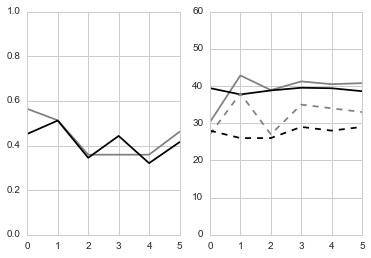

In [491]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,60)

plt.show()

In [ ]:
llh = {pid: 0 for pid in range(6)}
for i, row in df.iterrows():
    probid = row['probid']
    choice = row['choice']
    cp = row['cp']
    if choice == 0:
        llh[probid] += np.log(pfix(1 - cp))
    else:
        llh[probid] += np.log(pfix(cp))

In [ ]:
llh

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
plt.show()

In [ ]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot(df.groupby('probid').apply(lambda d: d.cp.mean()).values)
ax.set_ylim(0,1)
plt.show()

### CHASE + geom

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH2'
OUTDIR = 'process_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_stop_geom': P_STOP_GEOM['HPKH2']}

PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [493]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,1316.584042,5,234,2660.444689,0.000433,0.833131,1.167528,0.761687,0.655597


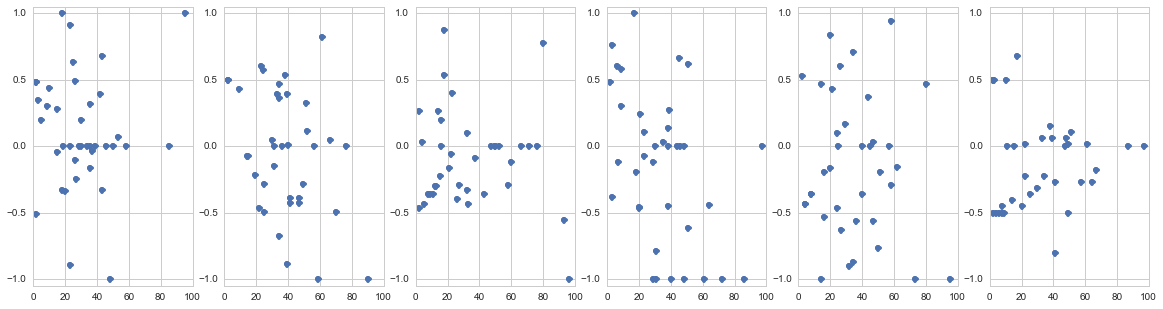

In [483]:
pred = {}
arr = []
for d in HPKH2_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,100)
plt.show()

In [498]:
for pid in range(6):
    print pid
    print problems[pid]

0
[[[ 3.   1. ]
  [ 0.   0. ]]

 [[ 4.   0.8]
  [ 0.   0.2]]]
1
[[[ 3.    0.25]
  [ 0.    0.75]]

 [[ 4.    0.2 ]
  [ 0.    0.8 ]]]
2
[[[-32.    0.1]
  [  0.    0.9]]

 [[ -3.    1. ]
  [  0.    0. ]]]
3
[[[-4.   0.8]
  [ 0.   0.2]]

 [[-3.   1. ]
  [ 0.   0. ]]]
4
[[[  3.    1. ]
  [  0.    0. ]]

 [[ 32.    0.1]
  [  0.    0.9]]]
5
[[[  3.00000000e+00   2.50000000e-01]
  [  0.00000000e+00   7.50000000e-01]]

 [[  3.20000000e+01   2.50000000e-02]
  [  0.00000000e+00   9.75000000e-01]]]


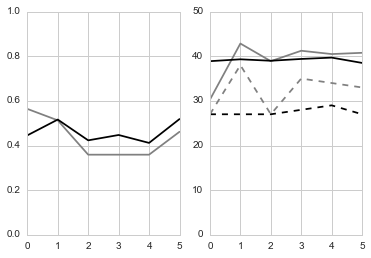

In [495]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'p_switch': P_SWITCH['HPKH2'],
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)
    
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,50)

plt.show()

In [ ]:
llh = {pid: 0 for pid in range(6)}
for i, row in df.iterrows():
    probid = row['probid']
    choice = row['choice']
    cp = row['cp']
    if choice == 0:
        llh[probid] += np.log(pfix(1 - cp))
    else:
        llh[probid] += np.log(pfix(cp))

In [ ]:
llh

In [ ]:
{0: -26.994788602372655,
 1: -22.985235037285271,
 2: -16.927245225174545,
 3: -27.251149138644049,
 4: -26.746905508212905,
 5: -19.132769547444727}

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
plt.show()

In [ ]:
lm = sns.lmplot(x="samplesize", y="choice", row="probid",
                data=df, logistic=False, y_jitter=.03)
for ax in lm.axes.ravel():
    ax.set_ylim(-.05,1.05)
    ax.set_xlim(0,100)

In [ ]:
lm = sns.lmplot(x="cp", y="choice", row="probid",
                data=df, logistic=False, y_jitter=.03)
for ax in lm.axes.ravel():
    ax.set_ylim(-.05,1.05)
    ax.set_xlim(-.05,1.05)

### CHASE (optional stopping)

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH2'
OUTDIR = 'process_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_switch': .1}

PARSETS = [#['theta', 'tau', 'pow_gain'],
           #['theta', 'tau', 'p_fixed', 'prelec_gamma', 'prelec_elevation'],
            ['theta', 'pow_gain', 'prelec_gamma', 'prelec_elevation']
           #['theta', 'tau', 'prelec_gamma', 'prelec_elevation', 'prelec_gamma_loss', 'prelec_elevation_loss', 'pow_gain']
          ]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='indifferent')
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [ ]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_switch': .1,
            #'phi': results.loc[0]['phi'],
            #'p_fixed': results.loc[0]['p_fixed'],
            #'p_stop_geom': results.loc[0]['p_stop_geom'],
            #'prelec_gamma': results.loc[0]['prelec_gamma'],
            #'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)
    
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot([pred[pid]['p_resp'][1] for pid in problems])
ax.set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems])
ax.plot([pred[pid]['samplesize'].mean() for pid in problems])
ax.set_ylim(0,50)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], color='black')
ax.set_ylim(0,40)
plt.show()

In [ ]:
pred[0]['samplesize']

In [ ]:
fig, axi = plt.subplots(2, 6, figsize=(15,8))

for pid in range(6):
    sns.distplot(data[data.problem==pid].samplesize.values, kde=False, ax=axi[1][pid])
    sns.distplot(pred[pid]['samplesize'], kde=False, ax=axi[0][pid], color='gray')
    
for i in range(2):
    for j in range(6):
        axi[i][j].set_xlim(0,200)

In [ ]:
# show the fitting results for the model with the lowest BIC
fitting = {p: PARS[p] for p in PARSETS[0]}
print best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

m = CHASEModel(drift='cpt', startdist='indifferent')
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)

# Recovery

In [ ]:
from cogmod import cpt as cptmodel

def fit_chase(problems, data, fit_pars):
        
    FIXED = {'dt': .1}
    N_ITER = 1
    SIM_ID = 'recover_process_data'
    OUTDIR = 'chase_fitresults_recover_process_data'

    fitting = {p: PARS[p] for p in fit_pars}

    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent',
                   problems=problems)

    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR, quiet=False)
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                               fitting = fitting, 
                               outdir=OUTDIR)

    return best, pred


PARS = {'theta': [1, 20],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

fitting_cpt = {'s': [0, np.inf, 1.],
               'prelec_gamma': [0, 10, 1.]}

def predicted_samplesize(pred):
    cp = pred['p_resp'][1]
    ss = pred['p_stop_cond'][:,1]*cp + pred['p_stop_cond'][:,0]*(1-cp)
    ss = ss/float(ss.sum())
    return np.array(ss)

def observed_samplesize(data):
    bc = np.bincount(data.samplesize)
    return bc/float(bc.sum())

def predicted_cp(pred):
    cp = pred['p_resp'][1]
    return cp

def observed_cp(data):
    return data.choice.mean()

In [ ]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}
#problems = {i: arr[i].reshape((2,2,2)) for i in range(1)}
#problems = [arr[i].reshape((2,2,2)) for i in range(len(arr))]

In [ ]:
with open('/Users/markant/code/chase/chase/paper/glockner_exp3_problems.pkl', 'r') as f:
    glockner_exp3_problems = pickle.load(f)

problems = {}
for p in glockner_exp3_problems:
    if np.sum(glockner_exp3_problems[p][:,:,0].ravel() < 0)==0:
        if np.random.random() < .05:
            problems[p] = glockner_exp3_problems[p]

In [ ]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)